In [138]:
import xml.etree.ElementTree as etree   

In [139]:
tree = etree.parse('roads_fixed.xml')

In [171]:
def clear_dataset(orders):
    orders.dropoffTime = pd.to_datetime(orders.dropoffTime)
    orders = orders[orders["fare"] < 500]
    orders = orders[orders.dropoffTime is not pd.NaT and (orders.dropoffTime < pd.Timestamp('2020-11-09 00:00:00'))]
    return orders

In [160]:
import pandas as pd
import numpy as np

In [190]:
orders = pd.read_csv('orders.csv')
print(len(orders))

935309


In [173]:
orders.head()

,driverID,dropoffTime,dropoff_lat,dropoff_lon,fare,pickupTime,pickup_lat,pickup_lon,rideRating
0,1152571,10/6/2020 21:34,49.83972,23.99442,26.63804,10/6/2020 20:54,49.70660,23.91523,5.0
1,3294889,10/6/2020 22:41,49.83972,23.99442,9.09288,10/6/2020 22:22,49.86757,24.04048,NaN
2,1695164,10/7/2020 10:25,49.83972,23.99442,6.84914,10/7/2020 10:14,49.83738,24.02959,5.0
3,2290241,10/7/2020 13:42,49.83972,23.99442,7.03987,10/7/2020 13:35,49.84659,24.03938,NaN
4,3442427,10/7/2020 15:29,49.83972,23.99442,12.55249,10/7/2020 14:49,49.81935,24.01403,NaN


In [191]:
orders = clear_dataset(orders)
print(len(orders))

935247


In [197]:
orders[['rideRating']] = orders[['rideRating']].fillna(value=-1)

In [198]:
from collections import defaultdict
grades = defaultdict(lambda: [0, 0])


for _, row in orders.iterrows():
    grades[row.driverID][0] += 1
    if row.rideRating == 5:
        grades[row.driverID][1] += 1

In [214]:
ratio = []
for key, value in grades.items():
    if value[0] > 99:
        ratio.append(value[1] / value[0])
ratio.sort()

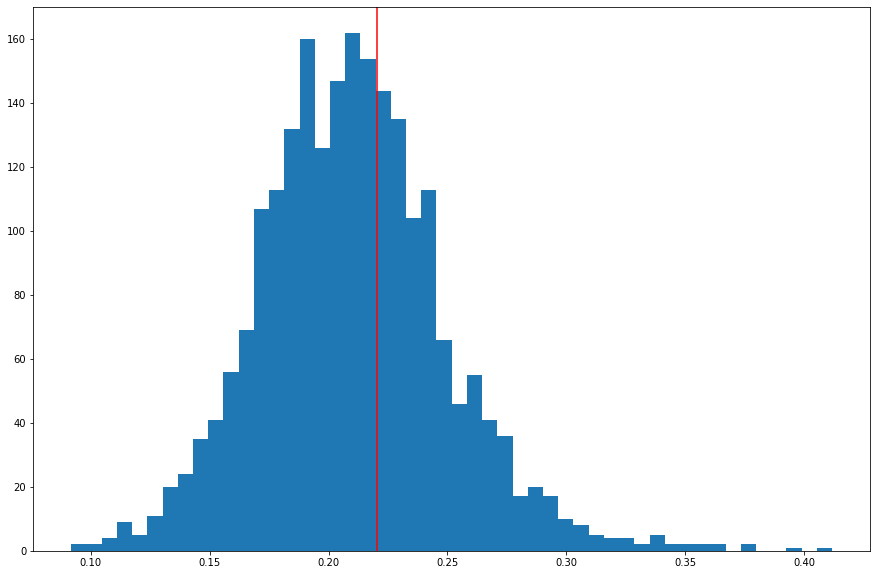

In [622]:
plt.figure(figsize=(15, 10))
plt.hist(ratio, bins=50)
plt.axvline(x=0.22058956, color='red')

In [626]:
from scipy import stats
np.random.seed(12345678)
x = stats.norm.rvs(loc=5, scale=3, size=100)
shapiro_test = stats.shapiro(ratio)
shapiro_test

(0.984703779220581, 1.0366313622116926e-14)

In [219]:
dr_count = len(ratio)
left_thresh = 0
left_count = 0
while left_count / dr_count < 0.16:
    left_thresh = ratio[left_count]
    left_count += 1
print(left_count, left_thresh)

356 0.17326057298772168


In [226]:
right_thresh = 0
right_count = 0
while right_count / dr_count < 0.16:
    right_count += 1
    right_thresh = ratio[dr_count - right_count]
print(right_count, right_thresh)

356 0.24479166666666666


Find day for each driver

In [409]:
import collections

In [446]:
drivers_ids = list(set(orders.driverID))
orders.pickupTime = pd.to_datetime(orders.pickupTime)

In [447]:
def get_rider_weekdays(rider):
    times = orders[orders['driverID'] == rider].pickupTime
    return np.array([t.weekday() for t in times])

def get_driver_days():
    driver_days = defaultdict(lambda: [0, 6])
    for driver in drivers_ids:
        wds = get_rider_weekdays(driver)
        c = collections.Counter(wds).most_common()
        if len(c) > 1:
            driver_days[driver] = [c[-2][0], c[-1][0]]
        if len(c) == 1:
            if c[0][0] == 0:
                driver_days[0] = 1
            elif c[0][0] == 6:
                driver_days[1] = 1
    return driver_days

def get_driver_cost():
    driver_cost = defaultdict(lambda: [[0, 0] for i in range(7)])
    for row in orders.to_numpy():
        weekday = row[5].weekday()
        driver_cost[row[0]][weekday][0] += 1 
        driver_cost[row[0]][weekday][1] += row[4]
    return driver_cost()

def get_driver_mean():
    driver_mean = defaultdict(lambda: [0] * 7)
    for driver in drivers_ids:
        for i in range(7):
            if driver_cost[driver][i][0] == 0:
                continue
            driver_mean[driver][i] = driver_cost[driver][i][1] / driver_cost[driver][i][0]
    return driver_mean

In [448]:
driver_days = get_driver_days()
driver_mean = get_driver_mean()

In [449]:
print(driver_days[drivers_ids[0]], driver_mean[drivers_ids[0]])

[1, 0] [11.577920833333332, 12.982262500000003, 8.85955857142857, 10.963812307692308, 11.645878000000002, 10.250815416666667, 14.98542923076923]


In [277]:
left = [x[0][0] for x in driver_days]
right = [x[1][0] for x in driver_days]

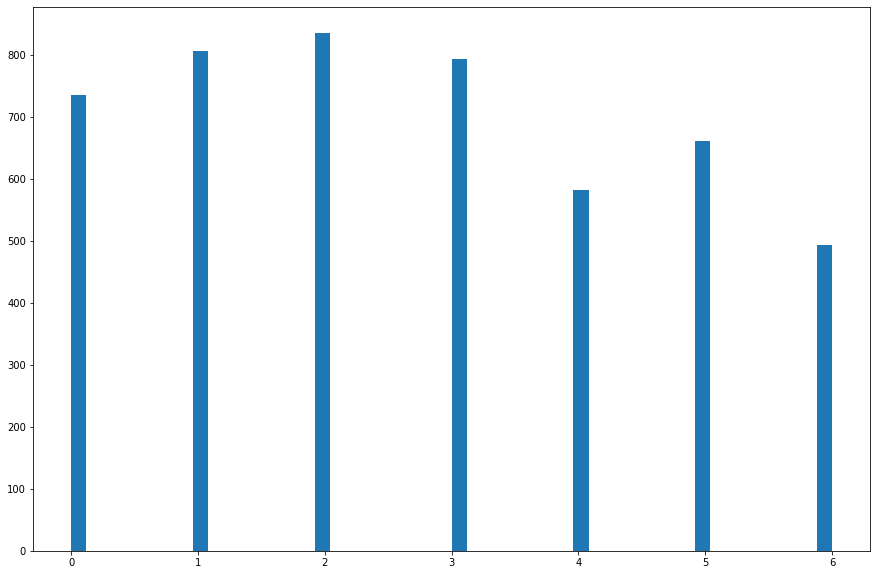

(array([ 765.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,  681.,
           0.,    0.,    0.,    0.,    0.,    0.,    0., 1032.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,  591.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,  454.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,  499.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,  889.]),
 array([0.  , 0.12, 0.24, 0.36, 0.48, 0.6 , 0.72, 0.84, 0.96, 1.08, 1.2 ,
        1.32, 1.44, 1.56, 1.68, 1.8 , 1.92, 2.04, 2.16, 2.28, 2.4 , 2.52,
        2.64, 2.76, 2.88, 3.  , 3.12, 3.24, 3.36, 3.48, 3.6 , 3.72, 3.84,
        3.96, 4.08, 4.2 , 4.32, 4.44, 4.56, 4.68, 4.8 , 4.92, 5.04, 5.16,
        5.28, 5.4 , 5.52, 5.64, 5.76, 5.88, 6.  ]),
 <a list of 50 Patch objects>)

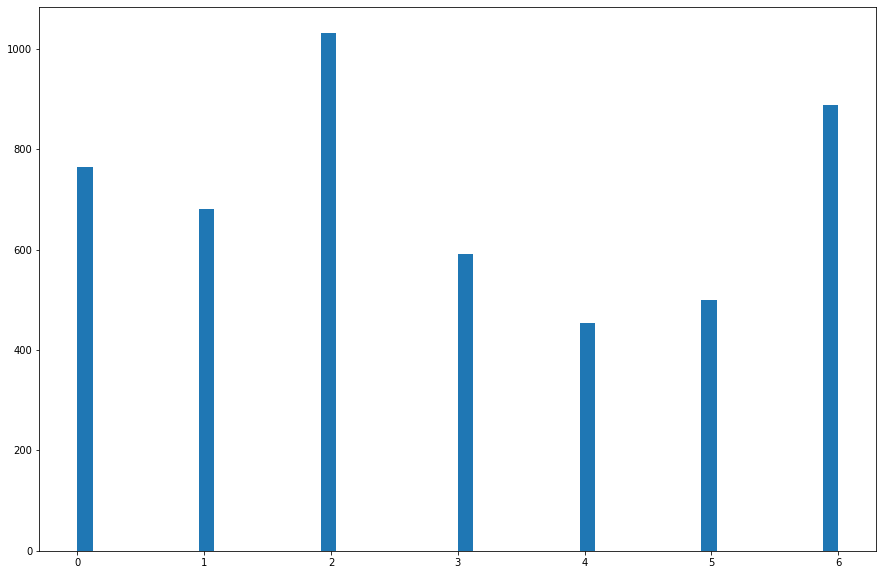

In [292]:
plt.figure(figsize=(15, 10))
plt.hist(left, bins=50)
plt.show()
plt.figure(figsize=(15, 10))
plt.hist(right, bins=50)

(array([1501.,    0.,    0.,    0.,    0.,    0.,    0.,    0., 1488.,
           0.,    0.,    0.,    0.,    0.,    0.,    0., 1868.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0., 1385.,    0.,
           0.,    0.,    0.,    0.,    0.,    0., 1037.,    0.,    0.,
           0.,    0.,    0.,    0.,    0., 1161.,    0.,    0.,    0.,
           0.,    0.,    0.,    0., 1382.]),
 array([0.  , 0.12, 0.24, 0.36, 0.48, 0.6 , 0.72, 0.84, 0.96, 1.08, 1.2 ,
        1.32, 1.44, 1.56, 1.68, 1.8 , 1.92, 2.04, 2.16, 2.28, 2.4 , 2.52,
        2.64, 2.76, 2.88, 3.  , 3.12, 3.24, 3.36, 3.48, 3.6 , 3.72, 3.84,
        3.96, 4.08, 4.2 , 4.32, 4.44, 4.56, 4.68, 4.8 , 4.92, 5.04, 5.16,
        5.28, 5.4 , 5.52, 5.64, 5.76, 5.88, 6.  ]),
 <a list of 50 Patch objects>)

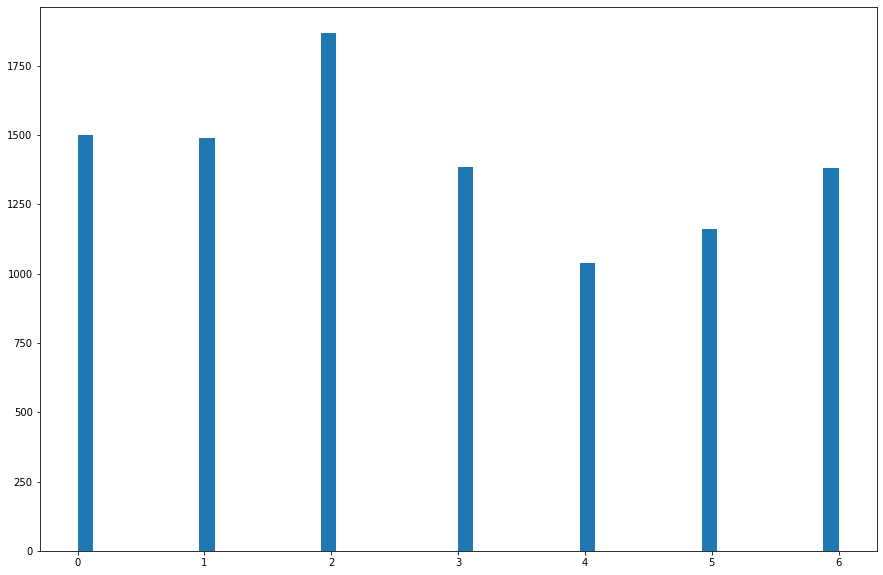

In [293]:
plt.figure(figsize=(15, 10))
plt.hist(right + left, bins=50)

Plot the average drive cost

In [325]:
res = orders.sort_values(['dropoffTime']).to_numpy()

In [327]:
print(res[0])

[3155598 Timestamp('2020-05-08 00:07:00') 49.80658 24.00098 8.0596
 '5/8/2020 0:02' 49.83245 24.01867 -1.0]


In [333]:
costs = [[1, res[0][4]]]

In [334]:
for i in range(len(res) - 1):
    if (res[i][1].day == res[i + 1][1].day):
        costs[-1][0] += 1
        costs[-1][1] += res[i + 1][4]
    else:
        costs.append([1, res[i + 1][4]])

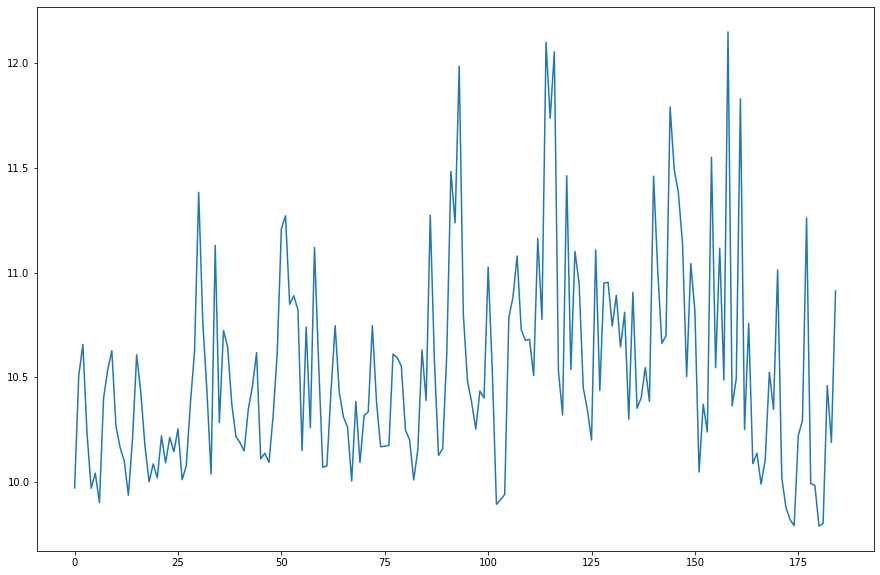

In [343]:
fare_ration = [x[1] / x[0] for x in costs]
plt.figure(figsize=(15, 10))
plt.plot(fare_ration)

Driver weekday average cost

In [175]:
times = pd.to_datetime(orders.dropoffTime)

In [176]:
print(times[0], times[0].month)
print(times.min())
print(times.max())

2020-10-06 21:34:00 10
2020-05-08 00:07:00
2020-11-08 23:59:00


In [177]:
times = times.sort_values().values

In [335]:
times = list(pd.to_datetime(times))

In [336]:
days = [[1, times[0]]]

In [337]:
for i in range(len(times) - 1):
    if (times[i].day == times[i+1].day):
        days[-1][0] += 1
    else:
        days.append([1, times[i + 1]])

In [338]:
print(days[-5:])

[[5182, Timestamp('2020-11-04 00:00:00')], [5672, Timestamp('2020-11-05 00:00:00')], [6573, Timestamp('2020-11-06 00:00:00')], [6384, Timestamp('2020-11-07 00:00:00')], [5499, Timestamp('2020-11-08 00:00:00')]]


In [184]:
days = np.array(days)

In [185]:
print(np.mean(np.array(days)[:, 0]))

5055.389189189189


<BarContainer object of 7 artists>

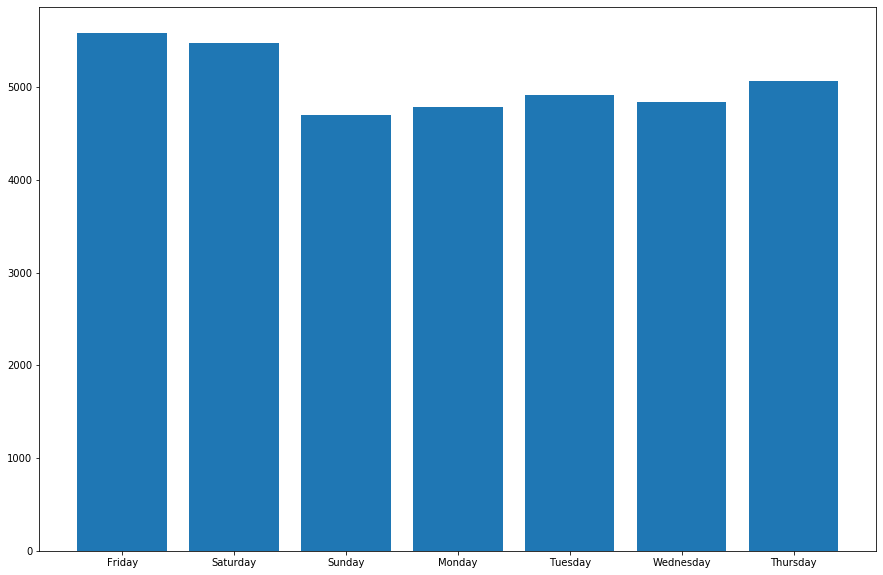

In [186]:
import calendar 

beg = times[0].weekday()
one = []
sec = []
for i in range(7):
    one.append(list(calendar.day_name)[(beg + i) % 7])
    sec.append(np.mean(days[i::7, 0]))

plt.figure(figsize=(15, 10))
plt.bar(one, sec)

In [187]:
import matplotlib.pyplot as plt
%matplotlib inline

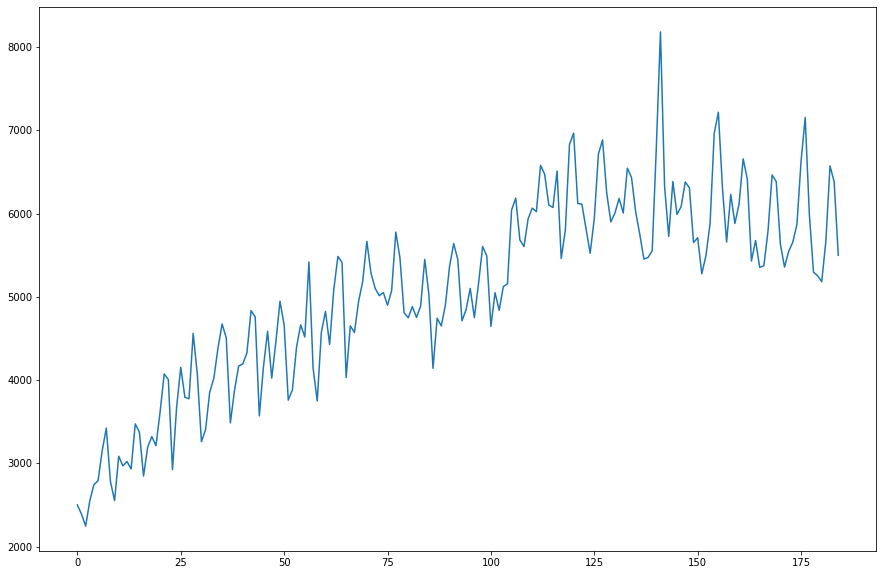

In [189]:
plt.figure(figsize=(15, 10))
plt.plot(days[:, 0])

Rest assignment ('drivers' changes its context)

In [435]:
!pip4 install haversine

  Using cached https://files.pythonhosted.org/packages/f4/52/a13286844780c7b1740edbbee8a8f0524e2a6d51c068b59dda39a6a119f5/haversine-2.3.0-py2.py3-none-any.whl


In [436]:
from haversine import haversine

In [460]:
def clear_dataset(orders):
    orders.dropoffTime = pd.to_datetime(orders.dropoffTime)
    orders = orders[orders["fare"] < 500]
    orders = orders[orders.dropoffTime is not pd.NaT and (orders.dropoffTime < pd.Timestamp('2020-11-09 00:00:00'))]
    orders[['rideRating']] = orders[['rideRating']].fillna(value=-1)
    return orders


def rider_class(rider, orders, thr1=0.28, thr2=0.17, thr3=0.23):
    grades = orders[orders['driverID'] == rider]['rideRating'].to_numpy()
    nrides = grades.shape[0]
    grades = [(grades == i).mean() for i in [-1, 1, 2, 3, 4, 5]]
    positive = grades[-1]
    # negative = sum(grades[1:-1])
    if nrides < 30:
        if positive > thr3:
            return 1
        return 2
    if positive > thr1:
        return 1
    if positive > thr2:
        return 2
    return 3


def get_long_dists(drivers):
    dists = np.zeros(drivers.shape[0], dtype='int')
    cx = orders.dropoff_lat.mean()
    cy = orders.dropoff_lon.mean()
    for i, row in drivers.iterrows():
        x = float(row['lat'])
        y = float(row['lon'])
        if haversine((x, y), (cx, cy)) > 10:
            dists[i] = 1
    return dists


def get_angle(c, p):
    if c[0] > p[0]:
        if c[1] > p[1]:
            return 1
        return 2
    if c[1] > p[1]:
        return 3
    return 4


def driver_features(drivers, orders):
    classes = [rider_class(drivers['driverID'][i], orders) for i in range(drivers.shape[0])]
    away = get_long_dists(drivers)
    drivers['away'] = away
    drivers['class'] = classes

    cx = orders.dropoff_lat.mean()
    cy = orders.dropoff_lon.mean()
    drivers['angle'] = [get_angle((cx, cy), (drivers['lat'][i], drivers['lon'][i])) for i in range(drivers.shape[0])]
    return drivers

In [461]:
drivers = driver_features(pd.read_csv('drivers.csv'), orders)

In [484]:
while one[0] != 'Monday':
    one = one[3:] + one[:3]
    sec = sec[3:] + sec[:3]
print(one, sec)

['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'] [4781.807692307692, 4919.192307692308, 4838.7307692307695, 5069.653846153846, 5582.0, 5475.185185185185, 4698.481481481482]


In [486]:
near_drivers = drivers[drivers.away == 0]

In [594]:
free_slots = len(near_drivers) * 2
aveps = np.sum(sec) / free_slots
slots = [free_slots / 7] * 7

for i in range(len(sec)):
    val = (sec[i] - np.mean(sec)) / aveps
    slots[i] -= val
    slots[i] = int(slots[i]) + 1

print(slots)

[1413, 1377, 1398, 1337, 1201, 1229, 1436]


In [601]:
def initial_distribution():
    res = [0] * 7
    driver_mean = get_driver_mean()
    distr = defaultdict(lambda: [0, 0])
    for _, row in near_drivers.iterrows():
        els = np.argsort(driver_mean[row.driverID])[:2]
        res[els[0]] += 1
        res[els[1]] += 1
        distr[row.driverID] = els
    return res, distr

In [602]:
ptr, driver_distr = initial_distribution()
print(ptr)

[1884, 1676, 1463, 1314, 719, 1272, 1060]


In [603]:
def is_p(i):
    return ptr[i] <= slots[i]

In [616]:
def adjust_second_class(driver_distr):
    second_class = near_drivers[near_drivers['class'] == 2]
    gdm = get_driver_mean()
    step = 0
    while any([not is_p(i) for i in range(7)]):
        step += 1
        change = None
        best_loss = 100000
        for i in range(7): 
            if not is_p(i):
                for _, d in second_class.iterrows():
                    ind = driver_distr[d.driverID]
                    if i in ind:
                        for j in range(7):
                            if ptr[j] < slots[j] and j not in ind:
                                loss = gdm[2][i] - gdm[2][j]
                                if loss < best_loss:
                                    best_loss = loss
                                    change = (i, j, d.driverID)

        if change is None:
            break
        
        ptr[change[0]] -= 1
        ptr[change[1]] += 1
        ind = driver_distr[change[2]]
        
        if ind[0] == change[0]:
            ind[0] = change[1]
        else:
            ind[1] = change[1]

[1413, 1377, 1398, 1337, 1201, 1229, 1433]
[1413, 1377, 1398, 1337, 1201, 1229, 1436]

[1413, 1377, 1398, 1337, 1201, 1229, 1433]
[1413, 1377, 1398, 1337, 1201, 1229, 1436]


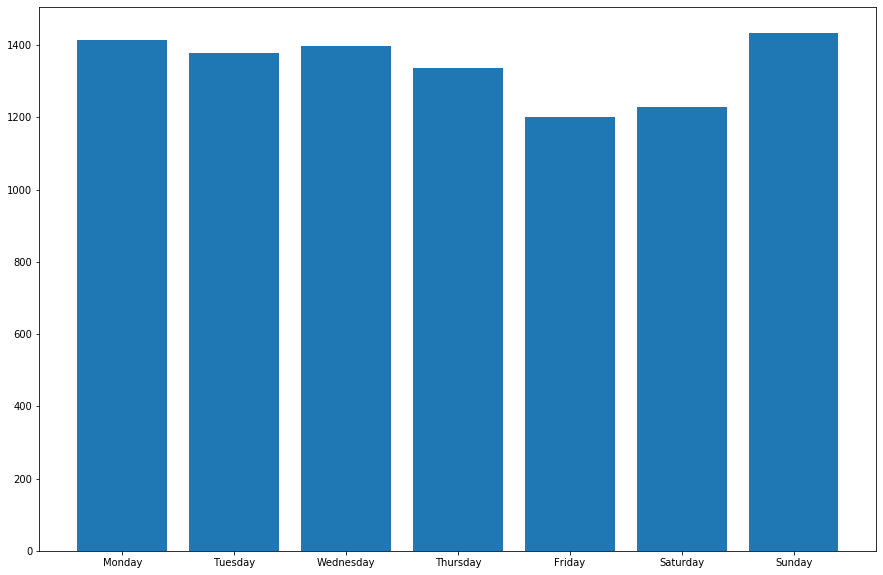

In [620]:
print(ptr)
print(slots)
plt.figure(figsize=(15, 10))
plt.bar(one, ptr)
adjust_second_class(driver_distr)
print()
print(ptr)
print(slots)